# KNN Imputation

## Purpose:


In [1]:
%load_ext autoreload

In [ ]:
# Imports
import os
import sys
import json
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pickle
import joblib
import csv
import warnings
import seaborn as sns
import openpyxl
from scipy import stats

# Sklearn Imports
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.impute import KNNImputer

# Py File Imports
%load_ext autoreload
from supporting_functions import get_fp, loadData, saveData

# Seed
np.random.seed(1776)

# Get Correct Filepath
#cpu = "surface"
cpu = "man_dtop"
#cpu = "sean"
folder_fp, data_fp, figures_fp = get_fp(cpu, "1.knnImp/")

# Get Data
rawPhys, rawRheo, physDict, rheoDict, imputedRheo = loadData(data_fp)

    
# Subset
abrSubset = ['donors', 'HCT', 'FIB', 'CHOL', 'TRIG', 'HDL', 'LDL', 
            'WBC', 'RBC', 'HEM', 'MCV', 'MCH', 'MCHC']

# Create a Mapping
rename_mapping = {}
for full_name, props in physDict.items():
    abbr = props.get('abbreviation')
    if abbr in abrSubset:
        rename_mapping[physDict[full_name]["column_name"]] = abbr
        
# Rename the columns
subset_Phys = rawPhys.rename(columns=rename_mapping)
#subset_Phys = subset_Phys[abrSubset]

# Clean NA from Rheological Data
cleanedRheo = rawRheo
# Remove Ibservation from Donor M
cleanedRheo = cleanedRheo[cleanedRheo["donors"] != "M"]

# Define Targets
rheo_targets = ["MU_0", "MU_INF", "TAU_C", "T_R1", "T_R2", "MU_R", "SIGMA_Y0", "TAU_LAM", "G_R", "G_C"]
rheo_targets_latex = [r"$\mu_0$", r"$\mu_{\infinity}$", r"$\tau_C$", r"$T_{R^1}$", r"$T_{R^2}$", r"$\mu_R$", r"$\sigma_{Y^{0}}$", r"$\tau_{\lambda}$", r"$G_R$", r"$G_C$"]
rheo_columns = [value["column_name"] for value in rheoDict.values()][1::]

# Define Donors
donors = rawRheo['donors'].values

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:

# KNN Imputation
n_neighbors=3

# Apply to rheological data
rheological_values = rawRheo[rheo_columns].values

imputer = KNNImputer(n_neighbors=min(n_neighbors, len(rheological_values)//2))
imputed_data = imputer.fit_transform(rheological_values)

# Extract target values
y_data = imputed_data

labels = []
for i in range(len(y_data)):
    letter_index = i if i < 4 else i + 1  # Skip E
    labels.append(chr(65 + letter_index))

# Create DataFrame
imputed_df = pd.DataFrame(
    y_data,
    columns=rheo_columns,
    index=labels
)

imputed_df.insert(0, 'donors', imputed_df.index)
imputed_values = imputed_df[rheo_columns].values
imputed_df



,donors,mu_0 (Pa s),mu_inf (Pa s),tau_C (s),t_r1 (s),t_r2 (s),mu_R (Pa s),sigma_y0 (Pa),tau_lam (s),G_R (Pa),G_C (Pa)
A,A,0.007466,0.003099,0.038674,0.930978,0.069219,0.016646,0.000857,1.113473,0.166702,0.577451
B,B,0.006539,0.003436,0.033835,0.821310,0.083485,0.021118,0.004301,1.942239,0.922792,0.760758
C,C,0.007796,0.003129,0.052720,2.087139,0.122056,0.063497,0.004778,1.268449,0.175228,0.806200
D,D,0.007449,0.003384,0.046501,2.709600,0.098971,0.113892,0.002239,1.268449,0.175228,0.806200
F,F,0.004830,0.002549,0.020133,0.990586,0.138290,0.018802,0.001276,1.149554,0.263225,0.663244
G,G,0.004286,0.003267,0.007779,0.479200,0.052526,0.014757,0.000047,0.986026,0.131786,0.723419
H,H,0.006667,0.003858,0.007740,0.902045,0.016441,0.045863,0.001687,3.497924,2.415642,1.195513
I,I,0.005244,0.003838,0.023144,0.703450,0.026578,0.039773,0.000400,3.745424,2.382311,1.325053
J,J,0.006277,0.003497,0.036688,0.991207,0.048693,0.040571,0.000004,1.082506,0.404235,0.734060
K,K,0.004103,0.003137,0.005685,0.305340,0.007726,0.016452,0.002873,0.939140,0.157178,0.388675


In [6]:
# Convert to DataFrame for easier analysis
original_df = pd.DataFrame(rawRheo, columns=rheo_columns, index=donors)
rawRheo_values = rawRheo[rheo_columns].values

# Calculate missing data statistics
missing_stats = {
    'Parameter': rheo_columns,
    'Missing_Count': [np.sum(np.isnan(rawRheo_values[:, i])) for i in range(len(rheo_columns))],
    'Missing_Percentage': [np.sum(np.isnan(rawRheo_values[:, i])) / len(rawRheo_values) * 100 
                            for i in range(len(rheo_columns))],
    'Complete_Count': [np.sum(~np.isnan(rawRheo_values[:, i])) for i in range(len(rheo_columns))]
}

missing_df = pd.DataFrame(missing_stats)

print("MISSING DATA ANALYSIS")
print("=" * 50)
print(f"Total samples: {len(rawRheo_values)}")
print(f"Total parameters: {len(rheo_columns)}")
print(f"Total data points: {len(rawRheo_values) * len(rheo_columns)}")
print(f"Missing data points: {np.sum(np.isnan(rawRheo_values))}")
print(f"Overall missingness: {np.sum(np.isnan(rawRheo_values)) / (len(rawRheo_values) * len(rheo_columns)) * 100:.1f}%\n")

print("PER-PARAMETER MISSING DATA:")
print("-" * 50)
for _, row in missing_df.iterrows():
    print(f"{row['Parameter']:<15}: {row['Missing_Count']:>2} missing ({row['Missing_Percentage']:>5.1f}%) | "
            f"{row['Complete_Count']:>2} complete")

MISSING DATA ANALYSIS
Total samples: 22
Total parameters: 10
Total data points: 220
Missing data points: 15
Overall missingness: 6.8%

PER-PARAMETER MISSING DATA:
--------------------------------------------------
mu_0 (Pa s)    :  0 missing (  0.0%) | 22 complete
mu_inf (Pa s)  :  0 missing (  0.0%) | 22 complete
tau_C (s)      :  0 missing (  0.0%) | 22 complete
t_r1 (s)       :  0 missing (  0.0%) | 22 complete
t_r2 (s)       :  0 missing (  0.0%) | 22 complete
mu_R (Pa s)    :  0 missing (  0.0%) | 22 complete
sigma_y0 (Pa)  :  0 missing (  0.0%) | 22 complete
tau_lam (s)    :  5 missing ( 22.7%) | 17 complete
G_R (Pa)       :  5 missing ( 22.7%) | 17 complete
G_C (Pa)       :  5 missing ( 22.7%) | 17 complete


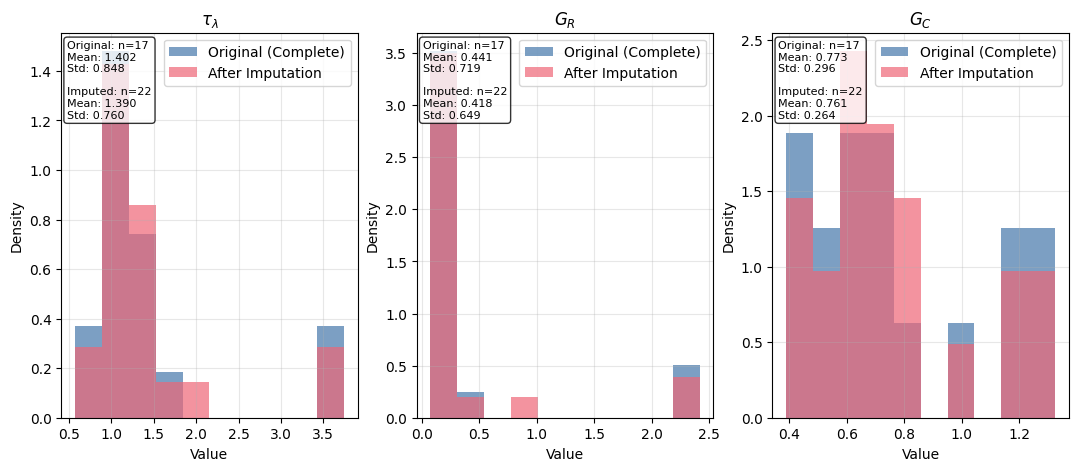

In [12]:
fig, axes = plt.subplots(1, 3, figsize=(13, 5))
axes = axes.flatten()

for i, param in enumerate(rheo_columns[-3:]):
    j = i+7
    # Get original data (excluding NaN values)
    original_vals = rawRheo_values[:, j]
    original_complete = original_vals[~np.isnan(original_vals)]

    # Get imputed data (all values)
    imputed_vals = imputed_values[:, j]
     
    # Create histogram comparison
    axes[i].hist(original_complete, bins=10, alpha=0.7, label='Original (Complete)', 
                color='#4477AA', density=True)
    axes[i].hist(imputed_vals, bins=10, alpha=0.7, label='After Imputation', 
                color='#EE6677', density=True)
    
    # Add statistics text
    stats_text = f'Original: n={len(original_complete)}\n'
    stats_text += f'Mean: {np.mean(original_complete):.3f}\n'
    stats_text += f'Std: {np.std(original_complete):.3f}\n\n'
    stats_text += f'Imputed: n={len(imputed_vals)}\n'
    stats_text += f'Mean: {np.mean(imputed_vals):.3f}\n'
    stats_text += f'Std: {np.std(imputed_vals):.3f}'
    
    axes[i].text(0.02, 0.98, stats_text, transform=axes[i].transAxes, 
                verticalalignment='top', fontsize=8,
                bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    axes[i].set_title(f'{rheo_targets_latex[j]}')
    axes[i].set_xlabel('Value')
    axes[i].set_ylabel('Density')
    axes[i].legend()
    axes[i].grid(True, alpha=0.3)
    
# Save the figure
plt.savefig(f'{figures_fp}s1_001_distributions.png', dpi=300, bbox_inches='tight')
plt.show()

/tmp/ipykernel_8700/3150199510.py:35: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=param_data, x='Type', y='Value', ax=axes[i],
/tmp/ipykernel_8700/3150199510.py:35: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=param_data, x='Type', y='Value', ax=axes[i],
/tmp/ipykernel_8700/3150199510.py:35: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=param_data, x='Type', y='Value', ax=axes[i],


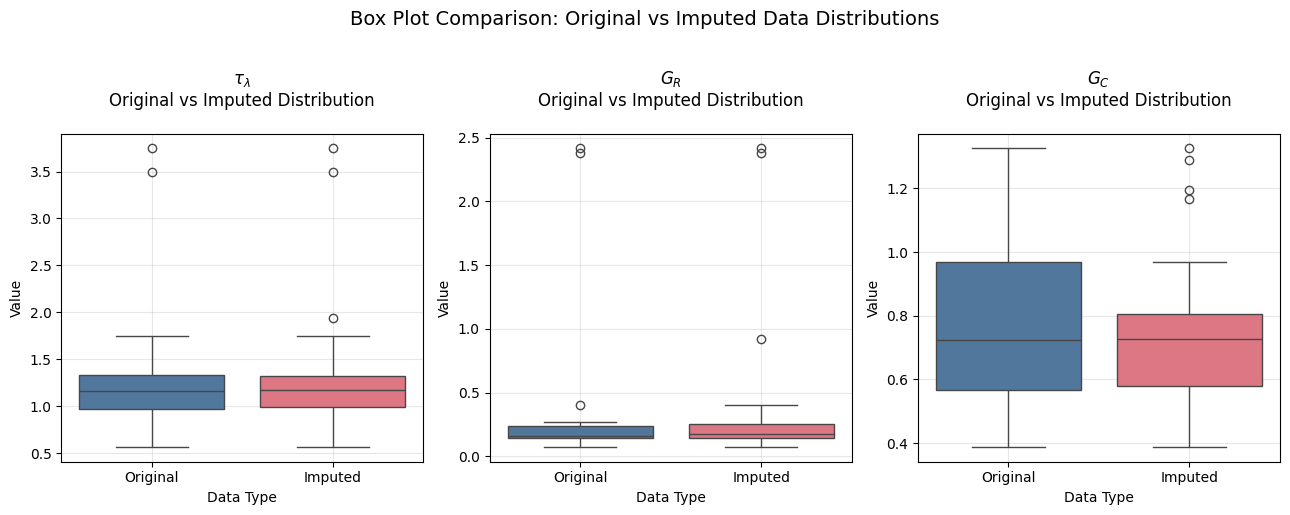

In [ ]:

"""
Create box plots comparing original vs imputed distributions using three subplots.
"""
# Prepare data for plotting
plot_data = []

for i, param in enumerate(rheo_columns[-3:]):
    j = i+7
    # Original complete data
    original_vals = rawRheo_values[:, j]
    original_complete = original_vals[~np.isnan(original_vals)]
    
    # Add original data points
    for val in original_complete:
        plot_data.append({'Parameter': param, 'Value': val, 'Type': 'Original'})
    
    # Add imputed data points
    imputed_vals = imputed_data[:, j]
    for val in imputed_vals:
        plot_data.append({'Parameter': param, 'Value': val, 'Type': 'Imputed'})

# Create DataFrame
plot_df = pd.DataFrame(plot_data)

# Create three subplots in a single row
fig, axes = plt.subplots(1, 3, figsize=(13, 5))

# Create individual box plots for each parameter
for i, param in enumerate(rheo_columns[-3:]):
    j = i+7
    # Filter data for current parameter
    param_data = plot_df[plot_df['Parameter'] == param]
    
    # Create box plot on the corresponding subplot
    sns.boxplot(data=param_data, x='Type', y='Value', ax=axes[i], 
                palette=['#4477AA', '#EE6677']) 
    
    # Customize each subplot
    axes[i].set_title(f'{rheo_targets_latex[j]}\nOriginal vs Imputed Distribution', fontsize=12, pad=20)
    axes[i].set_xlabel('Data Type', fontsize=10)
    axes[i].set_ylabel('Value', fontsize=10)
    axes[i].grid(True, alpha=0.3)
    
    # Optional: Rotate x-axis labels if needed
    axes[i].tick_params(axis='x', rotation=0)

# Add overall title for the entire figure
fig.suptitle('Box Plot Comparison: Original vs Imputed Data Distributions', 
             fontsize=14, y=1.02)

# Adjust spacing between subplots
plt.tight_layout()

# Save the figure
plt.savefig(f'{figures_fp}s1_002_boxplotComparison.png', dpi=300, bbox_inches='tight')
plt.show()